# Calculate path propagation/attenuation according to ITU-R P.452 (16)

## License

```
Calculate path propagation/attenuation according to ITU-R P.452 (16).
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycraf import pathprof
from pycraf import conversions as cnv
from astropy import units as u

## Doing generic studies

For spectrum compatibility studies on the ITU-R level, it is often necessary to do so-called generic studies. These are analyzing compatibility for the smooth-Earth scenario, i.e., assuming the terrain to be completely flat.

### Producing the zero-height profile
This is obviously trivial. We just produce a zero-filled numpy array and an appropriate distance vector.

In [3]:
distances = np.arange(0., 100., 0.05)  # 100 km in steps of 50-m
zero_hprof = np.zeros_like(distances)

As for the [terrain-based height profile](https://github.com/bwinkel/pycraf/blob/master/notebooks/03a_path_propagation_basic.ipynb), we first create a `PathProp` instance and call the `loss_complete` function afterwards. Since we use a custom height profile, the Tx/Rx coordinates are not relevant, but since the constructor wants to have a number, we will just feed in dummy values. We will also provide values for $\Delta N$ and $N_0$, the radiometerological parameters, as the P.452 algorithm needs them.

In [4]:
lon_t, lon_r = 0 * u.deg, 0 * u.deg
lat_t, lat_r = 50 * u.deg, 50 * u.deg
h_tg, h_rg = 10 * u.m, 50 * u.m  # Tx will be within clutter
G_t, G_r = 10. * cnv.dBi, 0. * cnv.dBi

frequency = 10 * u.GHz
temperature = 293.15 * u.K
pressure = 1013. * u.hPa

time_percent = 2 * u.percent
DN, N0 = 38. * cnv.dimless / u.km, 324. * cnv.dimless

zone_t, zone_r = pathprof.CLUTTER.URBAN, pathprof.CLUTTER.UNKNOWN

In [5]:
pprop = pathprof.PathProp(
    frequency,
    temperature, pressure,
    lon_t, lat_t,
    lat_t, lat_r,
    h_tg, h_rg,
    30. * u.m,  # dummy height resolution
    time_percent,
    zone_t=zone_t, zone_r=zone_r,
    delta_N=DN, N0=N0,
    hprof_dists=distances * u.km,
    hprof_heights=zero_hprof * u.m,
    hprof_bearing=90 * u.deg,  # have to provide dummy bearings
    hprof_backbearing=-90 * u.deg,
    )


The next step is to feed the `PathProp` object into the attenuation function:

In [6]:
tot_loss = pathprof.loss_complete(pprop, G_t, G_r)
(L_b0p, L_bd, L_bs, L_ba, L_b, L_b_corr, L) = tot_loss
print('L_b0p:    {0.value:5.2f} {0.unit} - Free-space loss'.format(L_b0p))
print('L_bd:     {0.value:5.2f} {0.unit} - Basic transmission loss associated with diffraction'.format(L_bd))
print('L_bs:     {0.value:5.2f} {0.unit} - Tropospheric scatter loss'.format(L_bs))
print('L_ba:     {0.value:5.2f} {0.unit} - Ducting/layer reflection loss'.format(L_ba))
print('L_b:      {0.value:5.2f} {0.unit} - Complete path propagation loss'.format(L_b))
print('L_b_corr: {0.value:5.2f} {0.unit} - As L_b but with clutter correction'.format(L_b_corr))
print('L:        {0.value:5.2f} {0.unit} - As L_b_corr but with gain correction'.format(L))


L_b0p:    153.89 dB - Free-space loss
L_bd:     200.98 dB - Basic transmission loss associated with diffraction
L_bs:     197.07 dB - Tropospheric scatter loss
L_ba:     174.22 dB - Ducting/layer reflection loss
L_b:      174.22 dB - Complete path propagation loss
L_b_corr: 190.32 dB - As L_b but with clutter correction
L:        180.32 dB - As L_b_corr but with gain correction


It is also interesting to study the attenuation effects as a function of distance:

In [7]:
# have to avoid the first few pixels, as each profile needs to have at
# least 5 or so values for the algorithm to work

# store attenuations in a numpy record for convenience (without units!)
attens = np.zeros(
    distances.shape, 
    dtype=np.dtype([
        ('LOS', 'f8'), ('Diffraction', 'f8'), ('Troposcatter', 'f8'), 
        ('Ducting', 'f8'), ('Total', 'f8'),
        ('Total w. clutter', 'f8'), ('Total w. clutter/gain', 'f8')
        ])
    )
attens[:5] = 1000.  # dB; initialize to huge value 

for idx in range(5, len(distances)):

    pprop = pathprof.PathProp(
        frequency,
        temperature, pressure,
        lon_t, lat_t,
        lat_t, lat_r,
        h_tg, h_rg,
        30. * u.m,  # dummy height resolution
        time_percent,
        zone_t=zone_t, zone_r=zone_r,
        delta_N=DN, N0=N0,
        hprof_dists=distances[:idx] * u.km,
        hprof_heights=zero_hprof[:idx] * u.m,
        hprof_bearing=90 * u.deg,  # have to provide dummy bearings
        hprof_backbearing=-90 * u.deg,
        )
    
    tot_loss = pathprof.loss_complete(pprop, G_t, G_r)
    attens[idx] = tuple(u.Quantity(tot_loss).value)

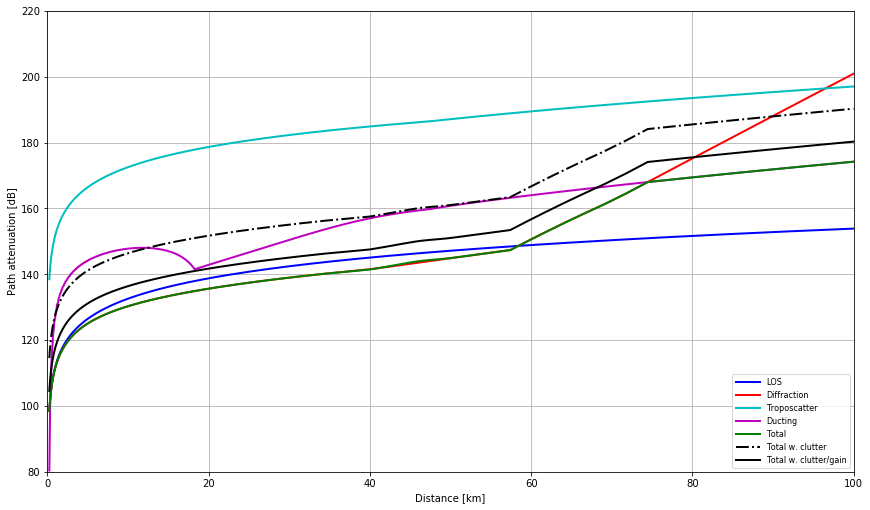

In [8]:
plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for (name, style) in zip(
        attens.dtype.names, 
        ['b-', 'r-', 'c-', 'm-', 'g-', 'k-.', 'k-']
        ):
    ax.plot(distances[5:], attens[name][5:], style, label=name, lw=2)

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.set_xlim((0, 100))
ax.set_ylim((80, 220))
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Path attenuation [dB]')
ax.grid()
plt.show()

With this, it is easy to see at which distance diffraction kicks in (at about 58 km), because the `L_bd` term shows a sharp bend at this point.

Again, pycraf has a function to do exactly this with less effort and improved computing speed:

In [9]:
distance = 100 * u.km
hprof_step = 50 * u.m

In [10]:
hprof_data = pathprof.height_path_data_generic(
    distance, hprof_step, lon_t, lat_t,
    zone_t=pathprof.CLUTTER.URBAN, zone_r=pathprof.CLUTTER.SUBURBAN,
    )

In [11]:
results = pathprof.atten_path_fast(
    frequency, temperature, pressure,
    h_tg, h_rg, time_percent,
    hprof_data,
    )

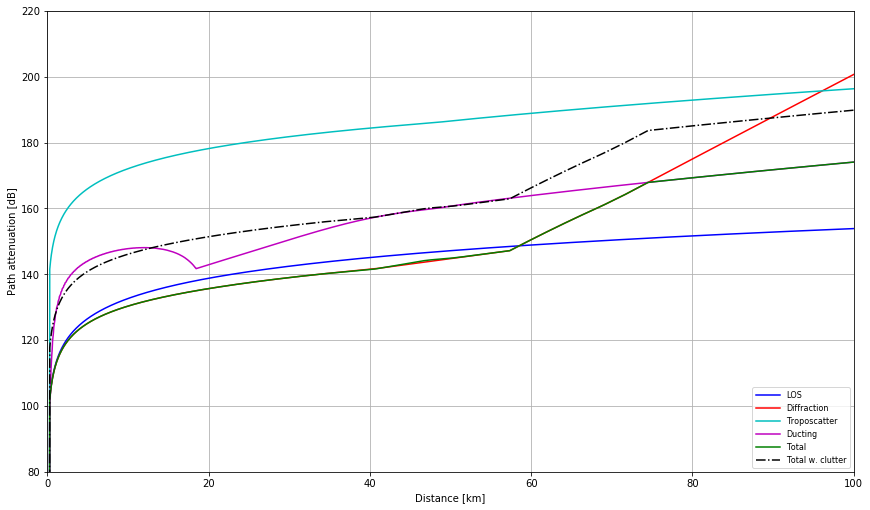

In [12]:
plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for key, name, style in zip(
        ['L_b0p', 'L_bd', 'L_bs', 'L_ba', 'L_b', 'L_b_corr'],
        attens.dtype.names[:-1], 
        ['b-', 'r-', 'c-', 'm-', 'g-', 'k-.']
        ):
    ax.plot(
        hprof_data['distances'][5:],
        results[key][5:],
        style, label=name
        )

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.set_xlim((0, 100))
ax.set_ylim((80, 220))
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Path attenuation [dB]')
ax.grid()
plt.show()